In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers,Input,optimizers

In [2]:

amazon = pd.read_csv("AMZN.csv")

def paint(data):
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)
    #data['Label'] = np.where(data['adj close'].shift(-1) > data['adj close'], 1, 0)
    #data['Label'] = (data['close'] > data['open']).astype(int)
    return data

amazon = paint(amazon)


tweets = pd.read_csv("D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Tweet.csv")
company_tweets = pd.read_csv(
    "D:\johnny的文件夹\FDU 课程\大二下\大数据商务分析\Final project\data\Tweet\Company_Tweet.csv")
tweets.drop('writer', axis=1, inplace=True)
df_tweets = pd.merge(tweets, company_tweets, on='tweet_id', how='left')
df_tweets['post_date'] = pd.to_datetime(df_tweets['post_date'], unit='s')
df_tweets['post_date'] = df_tweets['post_date'].dt.strftime('%Y-%m-%d')
df_tweets.drop('tweet_id', axis=1, inplace=True)
df_tweets['tweet_score'] = 1 * df_tweets['comment_num'] + 1 * df_tweets['retweet_num'] + 1.2 * df_tweets['like_num']
df_tweets = df_tweets[df_tweets['tweet_score'] >= 50].reset_index()
df_tweets.drop('index', axis=1, inplace=True)
df_tweets.drop('comment_num', axis=1, inplace=True)
df_tweets.drop('retweet_num', axis=1, inplace=True)
df_tweets.drop('like_num', axis=1, inplace=True)

df_tweets.rename(columns={'post_date': 'date'}, inplace=True)
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

def explore(df, company):
    df1 = df[df['ticker_symbol'] == company]
    score = df1.groupby('date')['tweet_score'].sum()
    df1 = pd.concat([score], axis=1)
    df1 = df1.reset_index()
    return df1
amazon_tweets = explore(df_tweets, 'AMZN')


def make_stock(stock, tweet):
    stock['date'] = pd.to_datetime(stock['date'])
    tweet['date'] = pd.to_datetime(tweet['date'])

    start_date = '2015-01-01'
    end_date = '2019-12-31'
    stock = stock.loc[(stock['date'] >= start_date) & (stock['date'] <= end_date)]
    result = pd.merge(stock, tweet, on='date', how='left')
    return result
amazon = make_stock(amazon, amazon_tweets).dropna()


In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

df=pd.DataFrame(amazon,columns=['date','open','close','tweet_score'])
data = df[['open','close','tweet_score']].values
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

# 创建数据集
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :2])  
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


[[1.31200263e-02 8.73304919e-03 2.37236097e-02]
 [1.30970395e-03 0.00000000e+00 4.74788719e-04]
 [0.00000000e+00 2.27918897e-03 3.16525813e-03]
 ...
 [9.11242433e-01 9.02814070e-01 1.30503593e-01]
 [9.06140804e-01 8.89694433e-01 1.18380654e-02]
 [8.87839089e-01 8.90238431e-01 1.43386193e-02]]


In [4]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 3)))  # 输入形状为(time_step, 2)
model.add(LSTM(units=50))
model.add(Dense(2))  # 输出一个值，即预测的closing价格

model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化
train_predict_full = np.concatenate((train_predict, np.zeros((train_predict.shape[0], 1))), axis=1)
test_predict_full = np.concatenate((test_predict, np.zeros((test_predict.shape[0], 1))), axis=1)
train_predict = scaler.inverse_transform(train_predict_full)[:, :2]
test_predict = scaler.inverse_transform(test_predict_full)[:, :2]


Epoch 1/40


C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1726 - val_loss: 0.0342
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0012 - val_l

In [5]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(train_mse, test_mse)
# accuracy, mse
# 相对于原始数据的涨跌

1699430.465926185 3355425.2251612125


In [6]:
open_predict = np.concatenate([train_predict[:,0], test_predict[:,0]], axis=0)
close_predict = np.concatenate([train_predict[:,1], test_predict[:,1]], axis=0)


In [7]:
open_predict.shape

(808,)

Text(0.5, 1.0, 'Stock Price Prediction')

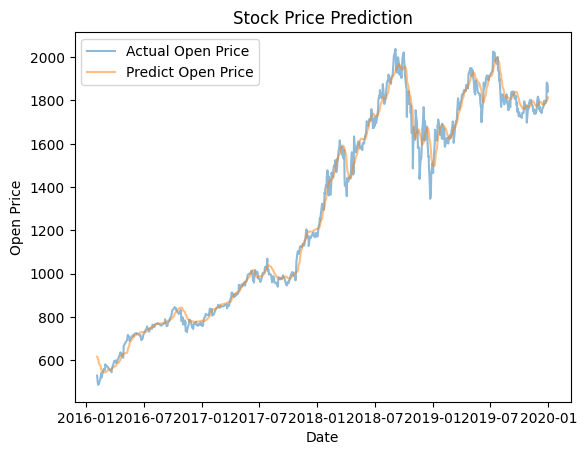

In [8]:
import matplotlib.pyplot as plt
plt.plot(df['date'][time_step:], df['open'][time_step:], label='Actual Open Price', alpha=0.5)
plt.plot(df['date'][time_step:], open_predict, label='Predict Open Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Price Prediction')

Text(0.5, 1.0, 'Stock Price Prediction')

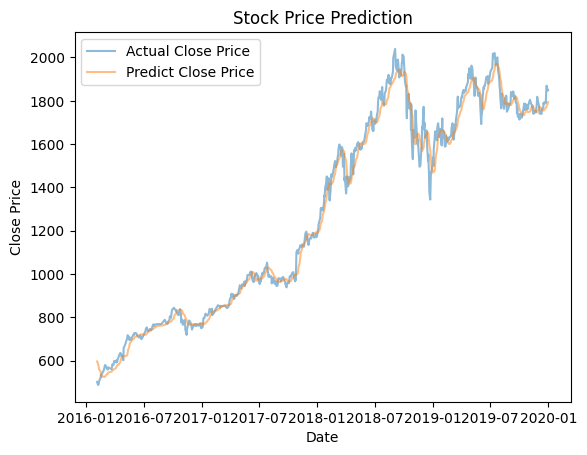

In [9]:
plt.plot(df['date'][time_step:], df['close'][time_step:], label='Actual Close Price', alpha=0.5)
plt.plot(df['date'][time_step:], close_predict, label='Predict Close Price', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction')

In [10]:
prediction = pd.DataFrame({'pre_open':open_predict, 'pre_close':close_predict})
prediction

,pre_open,pre_close
0,617.101260,596.721500
1,607.766445,586.108235
2,596.917306,573.658615
3,585.503780,560.874834
4,574.483986,549.114251
...,...,...
803,1791.133053,1768.123740
804,1794.642871,1771.910941
805,1799.249051,1776.900833
806,1806.063484,1784.478253


In [11]:
amazon.reset_index(inplace=True)
amazon_stock = pd.concat([amazon, prediction], axis=1)
amazon_stock

,index,date,open,high,low,close,adj close,volume,tweet_score,pre_open,pre_close
0,0,2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200,350.0,617.101260,596.721500
1,8,2015-01-14,291.929993,295.910004,286.500000,293.269989,293.269989,5538700,56.2,607.766445,586.108235
2,12,2015-01-21,289.640015,306.000000,287.260010,297.250000,297.250000,10065100,90.2,596.917306,573.658615
3,15,2015-01-26,311.820007,313.000000,307.519989,309.660004,309.660004,3169700,163.6,585.503780,560.874834
4,18,2015-01-29,304.730011,312.799988,299.329987,311.779999,311.779999,8656600,388.4,574.483986,549.114251
...,...,...,...,...,...,...,...,...,...,...,...
903,1253,2019-12-24,1793.810059,1795.569946,1787.579956,1789.209961,1789.209961,881300,162.2,NaN,NaN
904,1254,2019-12-26,1801.010010,1870.459961,1799.500000,1868.770020,1868.770020,6005400,1780.8,NaN,NaN
905,1255,2019-12-27,1882.920044,1901.400024,1866.010010,1869.800049,1869.800049,6186600,1699.4,NaN,NaN
906,1256,2019-12-30,1874.000000,1884.000000,1840.619995,1846.890015,1846.890015,3674700,199.8,NaN,NaN


In [12]:
amazon_stock['pre_Label'] = np.where(amazon_stock['pre_close'].shift(-1) > amazon_stock['pre_close'], 1, 0)
amazon_stock['Label'] = np.where(amazon_stock['close'].shift(-1) > amazon_stock['close'], 1, 0)
amazon_stock.dropna(inplace=True)

In [13]:
amazon_stock

,index,date,open,high,low,close,adj close,volume,tweet_score,pre_open,pre_close,pre_Label,Label
0,0,2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200,350.0,617.101260,596.721500,0,0
1,8,2015-01-14,291.929993,295.910004,286.500000,293.269989,293.269989,5538700,56.2,607.766445,586.108235,0,1
2,12,2015-01-21,289.640015,306.000000,287.260010,297.250000,297.250000,10065100,90.2,596.917306,573.658615,0,1
3,15,2015-01-26,311.820007,313.000000,307.519989,309.660004,309.660004,3169700,163.6,585.503780,560.874834,0,1
4,18,2015-01-29,304.730011,312.799988,299.329987,311.779999,311.779999,8656600,388.4,574.483986,549.114251,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,1139,2019-07-15,2021.400024,2022.900024,2001.550049,2020.989990,2020.989990,2981300,50.4,1791.133053,1768.123740,1,0
804,1140,2019-07-16,2010.579956,2026.319946,2001.219971,2009.900024,2009.900024,2618200,222.6,1794.642871,1771.910941,1,0
805,1141,2019-07-17,2007.050049,2012.000000,1992.030029,1992.030029,1992.030029,2558800,251.6,1799.249051,1776.900833,1,0
806,1142,2019-07-18,1980.010010,1987.500000,1951.550049,1977.900024,1977.900024,3504300,60.4,1806.063484,1784.478253,1,0


In [14]:
TP = ((amazon_stock['Label'] == 1) & (amazon_stock['pre_Label'] == 1)).sum()
FP = ((amazon_stock['Label'] == 0) & (amazon_stock['pre_Label'] == 1)).sum()
FN = ((amazon_stock['Label'] == 1) & (amazon_stock['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5669724770642202 0.665948275862069 0.6124876114965312


In [15]:
initial_fund = 10000
funds = initial_fund
for index in range(len(amazon_stock) - 1):
    if amazon_stock.loc[index, 'pre_Label'] == 1:
        # 在下一行的open买入股票
        funds += (amazon_stock.loc[index + 1, 'close'] - amazon_stock.loc[index + 1, 'open'])
print(funds)

9852.2607421875


In [16]:
X = []
y = []
for i in range(len(scaled_data)-100-7+1):
    X.append(scaled_data[i:i+100])
    y.append(scaled_data[i+100+7-1, 1])  
X = np.array(X)
y = np.array(y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(100, 3)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=40, batch_size=32,validation_data=(X_test, y_test))
predictions = []
for i in range(len(X) - split):
    predictions.append(model.predict(np.expand_dims(X[split+i], axis=0))[0, 0])
predictions = scaler.inverse_transform([[0, pred, 0] for pred in predictions])[:, 1]
print(predictions)

C:\Users\johnn\PycharmProjects\Deep Learning\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.1455 - val_loss: 0.0413
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 

In [17]:
predictions = pd.DataFrame(predictions, columns=['pred'])
num = len(amazon) - len(predictions)
df = amazon[num:]
df.reset_index(inplace=True)
stock1 = pd.concat([df, predictions], axis=1)
stock1['pre_Label'] = np.where(stock1['pred'].shift(-1) > stock1['pred'], 1, 0)
stock1['Label'] = np.where(stock1['close'].shift(-1) > stock1['close'], 1, 0)
TP = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 1)).sum()
FP = ((stock1['Label'] == 0) & (stock1['pre_Label'] == 1)).sum()
FN = ((stock1['Label'] == 1) & (stock1['pre_Label'] == 0)).sum()

# 计算 Precision 和 Recall
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)

0.5357142857142857 0.5555555555555556 0.5454545454545454
